# How to model an evaporation/boiling process?

This notebook summarizes the key ideas of modeling evaporation and/or boiling in simplified systems.

The goal of the approach is to be energetically consistent but not really physically formal (at least for now).

We start by importing the required tools.

In [1]:
from casadi import Function
from casadi import SX
from casadi import jacobian
from casadi import sign
from scipy.integrate import cumtrapz
from scipy.integrate import solve_ivp
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Simple evaporation rate model

Increasing temperature should increase vapor pressure of water till a saturation is reached.

Under given external conditions, this could be parametrized in terms of a sigmoid function as:

$$
\dot{m}_{evap} = \frac{\dot{m}_{max}}{1 + \exp\left[-k\left(T-T_{b}\right)\right]}\qquad\left[{kg}\cdotp{m}^{-2}\cdotp{s}^{-1}\right]
$$

Parameter $T_b$ is not boiling point, but a value below that so that saturation is reached at boiling and the breadth of the dispersion is given by $k$.

In code that means:

In [2]:
def evaporation_rate(T, scale, Tb=368.0, k=2.0):
    """ Hypotethical evaporation rate [kg/(m².s)]. """
    return scale / (1.0 + np.exp(-k * (T - Tb)))

The plot below displays the curve above with default parameters for better understanding.

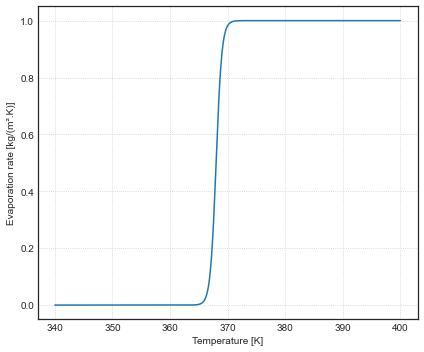

In [3]:
def plot_evaporation_rate():
    """ Wrap the plotting ot `evaporation_rate`. """
    T = np.linspace(340, 400, 1000)
    mdot = evaporation_rate(T, scale=1)

    plt.close("all")
    plt.style.use("seaborn-white")
    plt.figure(figsize=(6, 5))
    plt.plot(T, mdot)
    plt.grid(linestyle=":")
    plt.xlabel("Temperature [K]")
    plt.ylabel("Evaporation rate [kg/(m².K)]")
    plt.tight_layout()

plot_evaporation_rate()

## Boiling pot

Consider a system of variable size representing the water in a pot (not the whole volume inside the pot).

Its change in total enthalpy in time depends on heat inputs and losses.

Say a heat source $\dot{q}_{in}$ is place below the pot and its walls and water free surface are adiabatic (hard to believe).

Thus one can write $\dot{H}=\dot{q}_{in}$ as the energy balance, but $H=mh$, with $h$ the specific enthalpy, thus

$$
\dfrac{dH}{dt}=\dfrac{d(mh)}{dt}=m\dfrac{dh}{dt}+\dfrac{dm}{dt}h=m\dfrac{dh}{dt}-\dot{m}_{evap}h=\dot{q}_{in}
$$

because the only source of mass change is evaporation, then the mass derivative equals minus the evaporation rate, $\dot{m}=-\dot{m}_{evap}$.

We also have at constant pressure $dh=c_{p}dT$ and the latent enthalpy of evaporation is $L$, so it can be rewritten

$$
\dfrac{dT}{dt}=\dfrac{\dot{q}_{in}+\dot{m}L}{mc_{P}}
$$

Once boiling start there should be no temperature change, so all the heat must be used for evaporation.

Under that circumstance the total boiling rate must be given by

$$
\dot{m}_{evap}=\dfrac{\dot{q}_{in}}{L}
$$

To wrap-up we still need the properties of water, given below:

In [4]:
# Water specific heat [J/(kg.K)].
cp_w = 4180.0

# Water specific latent enthalpy of evaporation [J/kg].
L_w = 2257166.0

Let's put the system of ODE's in form of code (for an area of 1 m²).

The Heaviside approximation given by `active` simply avoid some overflows during model evaluation near the end.

In [5]:
def model(t, x, q_in, mtol):
    """ Model for testing the approach. """
    # Unpack solution variables.
    m, T = x

    # Right-hand side of problem.
    mdot = -evaporation_rate(T, scale=q_in / L_w)
    Tdot = (q_in + mdot * L_w) / (m * cp_w)

    # Water left (within tolerance) to evaporate?
    active = (1.0 + sign(m - mtol)) / 2.0
    
    return [active * mdot, active * Tdot]

Because simulating this system for negative masses has no meaning, we add a stop criteria.

In [6]:
class stop_criteria_mT:
    """ Stop simulation when evaporation finishes. """
    terminal = True
    direction = -1.0

    def __call__(self, t, x, q_in, mtol):
        """ Returns negative when mass is around zero. """
        return x[0] - mtol

A function for plotting the integration of the model is also provided.

In [7]:
def plot_pot_boiling(t, m, T):
    """ Plot results from pot boiling experiment. """
    plt.close("all")
    plt.style.use("seaborn-white")

    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    ax = ax.T.ravel()

    ax[0].plot(t, T)
    ax[0].grid(linestyle=":")
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Temperature [K]")

    ax[1].plot(t, m)
    ax[1].grid(linestyle=":")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Mass [kg]")

    ax[2].plot(m, T)
    ax[2].grid(linestyle=":")
    ax[2].set_xlabel("Mass [kg]")
    ax[2].set_ylabel("Temperature [K]")

    ax[3].axis("off")

    fig.tight_layout()

In the cell below you can play with heat input and initial conditions to investigate their effect.

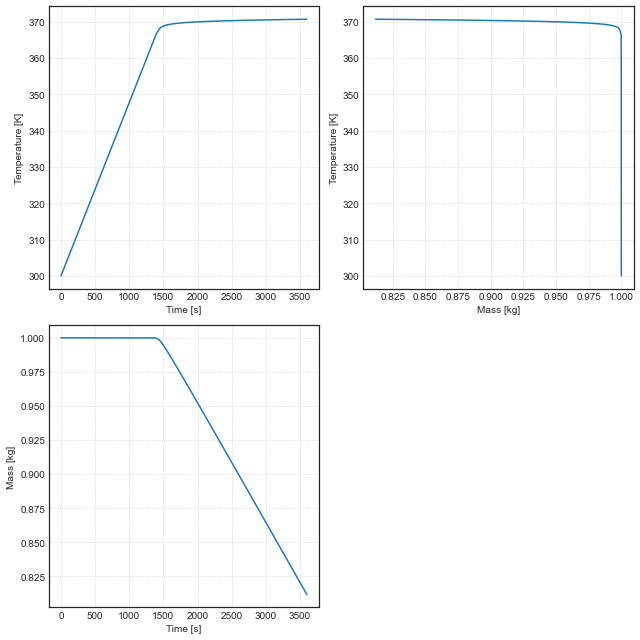

In [8]:
# Tolerance for mass [kg].
mtol = 1.0e-06

# Heat input in the container [W].
q_in = 200.0

# Initial state [kg, K].
y0 = [1.0, 300.0]

# Time-span of calculations and evaluation points [s].
t_span = (0.0, 3600)
t_eval = np.linspace(*t_span, int(t_span[1])+1)

# Problem is stiff, use an appropriate solver.
results = solve_ivp(model, t_span, y0, t_eval=t_eval,
                    args=(q_in, mtol), method="LSODA",
                    events=stop_criteria_mT())

# Unpack solution.
t = results.t
m, T = results.y

# Did it converge?
if results.success:
    plot_pot_boiling(t, m, T)

## Drying of solids

The previous model can be generalized for the evaporation of fluids from solids.

Next we generalize the system for including a mass fraction of fluids in a solid to be dried.

The simple model is proposed as a set of mass, species, and energy equations:

$$
\begin{align}
\dfrac{dm}{dt}&=-\dot{m}_{evap}\\[6pt]
\dfrac{dY}{dt}&=\dfrac{\dot{m}}{m}\\[6pt]
\dfrac{dT}{dt}&=\dfrac{\dot{q}_{in}+\dot{m}L}{mc_{P}}
\end{align}
$$

where the consitutive laws for mass averaged specific heat is given by:

$$
\begin{align}
c_{p}&=Yc_{p,w} + (1-Y)c_{p,b}\\[6pt]
\end{align}
$$

Notice that we could solve only 2 equations by making a transformation in mass equation definition, but that would shadow the generality of the model for any number of species.

Now we only need the specific heat of the solid, here $SiO_2$ and we are ready to go.

In [9]:
# Silica specific heat [J/(kg/k)].
cp_b = 742.34

In what follows the `active` takes the actual meaning it should (not only the auxiliary role in previous example): stop mass loss once the mass fraction of water falls to zero.

Also notice that we are clipping the bounds of `Y` so that the solver does not try anything unphysical.

In [10]:
def model(t, x, q_in, mtol):
    """ Model for testing the approach. """
    # Unpack solution variables.
    m, Y, T = x

    # Bound mass fraction [solver doesn't know that!].
    Y = np.clip(Y, 0, 1)

    # Mass fraction averaged specific heat [J/(kg.K)].
    cp = Y * cp_w + (1.0 - Y) * cp_b

    # Water current evaporation rate [kg/(s)].
    wdot = evaporation_rate(T, scale=q_in / L_w)

    # Water left (within tolerance) to evaporate?
    active = (1.0 + sign(Y - mtol)) / 2.0

    # Right-hand side of problem.
    mdot = -active * wdot
    Ydot = mdot / m
    Tdot = (q_in + mdot * L_w) / (m * cp)

    return [mdot, Ydot, Tdot]

If you want to stop the simulation, now that must be done with mass fraction instead of mass.

This will be disabled by default in the example the follows.

In [11]:
class stop_criteria_mYT:
    """ Stop simulation when evaporation finishes. """
    terminal = True
    direction = -1.0

    def __init__(self, disable) -> None:
        self._disabled = disable

    def __call__(self, t, x, q_in, mtol):
        """ Returns negative when mass fraction is around zero. """
        return 1.0 if self._disabled else (x[1] - mtol)

Again we provide a helper plotting function.

In [12]:
def plot_drying_solids(t, m, Y, T):
    """ Plot results from solids drying experiment. """
    plt.close("all")
    plt.style.use("seaborn-white")

    fig, ax = plt.subplots(3, 2, figsize=(12, 9))
    ax = ax.T.ravel()

    ax[0].plot(t, T)
    ax[0].grid(linestyle=":")
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Temperature [K]")

    ax[1].plot(t, Y)
    ax[1].grid(linestyle=":")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Mass fraction [-]")

    ax[2].plot(t, m)
    ax[2].grid(linestyle=":")
    ax[2].set_xlabel("Time [s]")
    ax[2].set_ylabel("Mass [kg]")


    ax[3].plot(m, T)
    ax[3].grid(linestyle=":")
    ax[3].set_xlabel("Mass [kg]")
    ax[3].set_ylabel("Temperature [K]")

    ax[4].plot(m, Y)
    ax[4].grid(linestyle=":")
    ax[4].set_xlabel("Mass [kg]")
    ax[4].set_ylabel("Mass fraction [-]")

    ax[5].axis("off")

    fig.tight_layout()

And finally the simulation can be run.

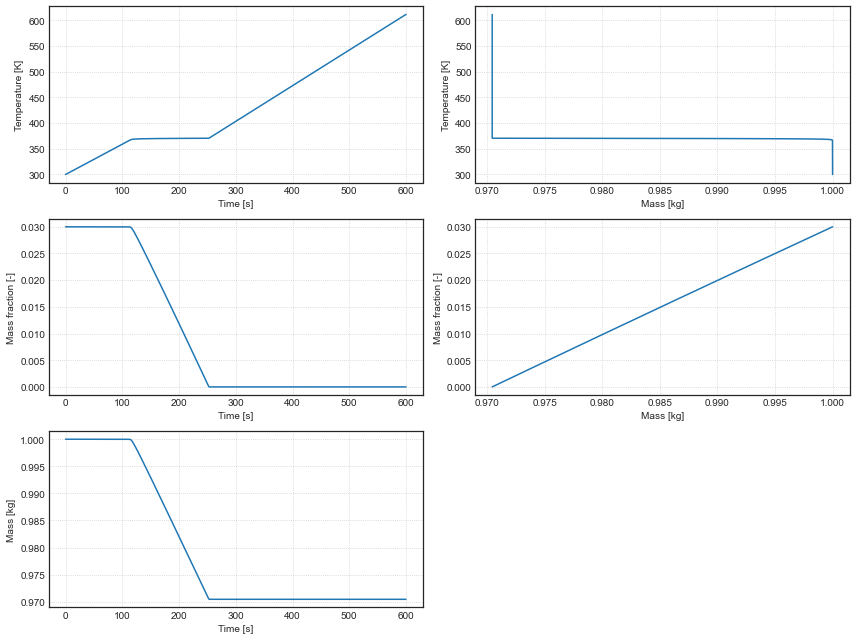

In [13]:
# Tolerance for mass [kg].
mtol = 1.0e-06

# Heat input in the container [W].
q_in = 500.0

# Initial state [kg, K].
y0 = [1.0, 0.03, 300.0]

# Time-span of calculations and evaluation points [s].
t_span = (0.0, 600)
t_eval = np.linspace(*t_span, int(t_span[1])+1)

# Problem is stiff, use an appropriate solver.
results = solve_ivp(model, t_span, y0, t_eval=t_eval,
                    args=(q_in, mtol), method="LSODA",
                    events=stop_criteria_mYT(True))

# Unpack solution.
t = results.t
m, Y, T = results.y

# Did it converge?
if results.success:
    plot_drying_solids(t, m, Y, T)

## Energy consistency only

In some cases we don't need to compute mass conservation but are only interested in energy consistency.

What follows present some tricks for reaching that by playing with the expression for specific heat.

For the illustration purposes we use a `ct.Water` object in a `ct.SolutionArray` for computing properties.

A temperature range representative of water from room temperature to gas is considered here.

All the properties in what follow are assumed to be at constant pressure, so it is omitted in the names.

In [14]:
T = np.linspace(0, 200, 4000) + 273.16

liq = ct.Water()
liq.basis = "mass"

sol = ct.SolutionArray(liq, shape=T.shape)
sol.TP = T, ct.one_atm * np.ones_like(T)

Prior to any computations we recover the quantities of interest, specific heat `cp` and specific enthalpy `hm`.

Notice that given the `mass` basis declared before these quantities are per mass unit [kg].

In [15]:
cp_ref = sol.cp
hm_ref = sol.h

Since the `ct.Water` has no latent heat attribute and this value is recovered by filtering the array.

Enthalpy change is computed and one may check this value is as reported in the literature.

**Note:** do not use equality here because you might get a zero depending on how `T` was constructed.

In [16]:
Tb = 373.15

hb = hm_ref[(T < Tb)][-1]
ha = hm_ref[(T > Tb)][0]
dh = ha - hb

dh

2257166.191140862

Next step is to compute a *modified* specific heat by incorporating a smeared latent heat contribution around the boiling point.

It must be emphasized that the breadth of the smearing depends on how you intend to integrate the equations later.

It is funny and reconforting to see that the ration on the r.h.s. here is the definition of specific heat at the limit $\Delta{}T\rightarrow{}0$.

In [17]:
dT = 10

cp_mod = cp_ref.copy()
cp_mod[(T > Tb-dT/2) & (T < Tb+dT/2)] += dh / dT

From the definition of enthalpy change computed from a reference temperature we have:

$$
H(T) = \Delta^{f}H(T_{ref}) + \int_{T_{ref}}^{T}c_{P}(T)dT
$$

Thus we perform this integration numerically and check against a relative tolerance.

In [18]:
rtol = 5.0e-04

hm_mod = [0, *cumtrapz(cp_mod, T)]
hm_mod = hm_ref[0] + np.array(hm_mod)

dh_ref = hm_ref[-1] - hm_ref[0]
dh_mod = hm_mod[-1] - hm_mod[0]

error = abs((dh_mod - dh_ref) / dh_ref)
error < rtol, error

(True, 0.000250655731557969)

From that we see that total enthalpy change is conserved to within approximately 0.02%, what is good for our purposes.

Finally we display a comparison plot of the reference curves and their modified version.

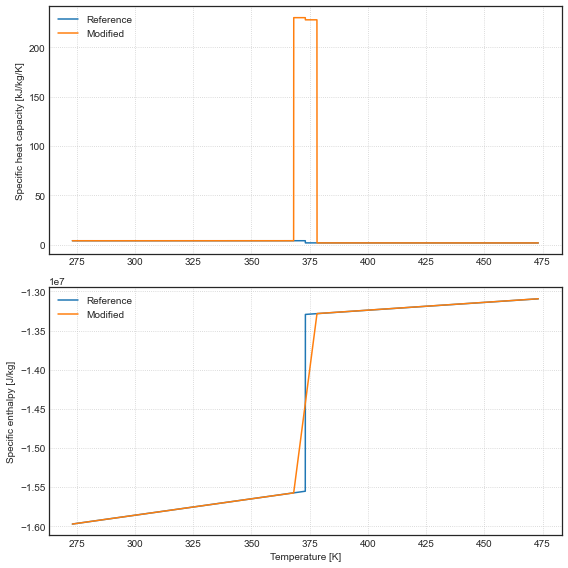

In [19]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(8, 8))

ax = plt.subplot(212)
plt.plot(T, hm_ref, label="Reference")
plt.plot(T, hm_mod, label="Modified")
plt.grid(linestyle=":")
plt.xlabel("Temperature [K]")
plt.ylabel("Specific enthalpy [J/kg]")
plt.legend(loc=2)

ax = plt.subplot(211, sharex=ax)
plt.plot(T, cp_ref/1000, label="Reference")
plt.plot(T, cp_mod/1000, label="Modified")
plt.grid(linestyle=":")
plt.ylabel("Specific heat capacity [kJ/kg/K]")
plt.legend(loc=2)

plt.tight_layout()

Results so far are numerically good but the steps in the functions are not analytical and can be a problem with automatic differentiation (AD).

In what follows we work towards a *discontinuous differentiable* function (that makes no mathematical sense, but works when dealing with AD)!

A Heaviside function can be implemented with the `sign` function as

$$
H(x, x_0) = \frac{1 + sign(x-x_0)}{2}
$$

which evaluates to 1 when $x>x_0$ and 0 when $x<x_0$ (the value at the equality is implementation dependent, often set to 0.5).

Below we illustrate the computation of a square hump around zero.

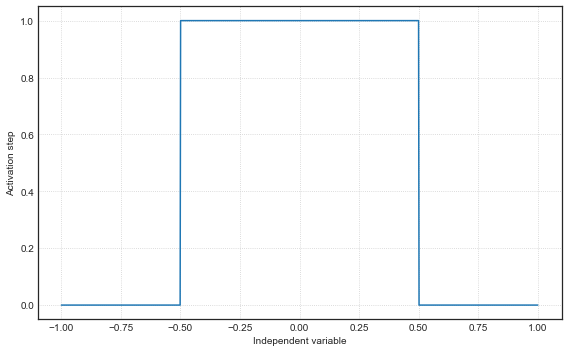

In [20]:
t = np.linspace(-1, 1, 1000)

g0 = (1.0 + sign(t-0.5)) / 2
g1 = (1.0 + sign(t+0.5)) / 2
g = g1 - g0

plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(8, 5))
plt.plot(t, g.full().ravel())
plt.grid(linestyle=":")
plt.xlabel("Independent variable")
plt.ylabel("Activation step")
plt.tight_layout()

Now we define the change temperatures `tc` and the increments `dxy` for the steps.

In [21]:
tc0 = Tb - dT / 2
tc1 = Tb
tc2 = Tb + dT / 2

c0 = cp_mod[(T < tc0)].mean()
c1 = cp_mod[(T > tc0) & (T <= tc1)].mean()
c2 = cp_mod[(T > tc1) & (T <= tc2)].mean()
c3 = cp_mod[(T > tc2)].mean()

d01 = c1 - c0
d12 = c2 - c1
d23 = c3 - c2

Using a sequence of stepwise functions we reconstruct the original specific heat function.

By incremental changes one also find some *analytical* enthalpy function.

In [22]:
T_ref = 273.16

Ts = SX.sym("Ts")
g0 = (1.0 + sign(Ts - tc0)) / 2
g1 = (1.0 + sign(Ts - tc1)) / 2
g2 = (1.0 + sign(Ts - tc2)) / 2

c = c0 + d01 * g0 + d12 * g1 + d23 * g2

h = c0 * (Ts - T_ref)
h += g0 * (c1 - c0) * (Ts - tc0)
h += g1 * (c2 - c1) * (Ts - tc1)
h += g2 * (c3 - c2) * (Ts - tc2)

cp_w = Function("cp_w", [Ts], [c])
hm_w = Function("hm_w", [Ts], [h])

cp_int = cp_w(T).full().ravel()
hm_int = hm_w(T).full().ravel() + hm_ref[0]

Energy conservation in this simplified approach - we are piecewise neglecting $c_P=c_P(T)$ - we find it is about 10 times better!

In [23]:
dh_ref = hm_ref[-1] - hm_ref[0]
dh_int = hm_int[-1] - hm_int[0]

error = abs((dh_int - dh_ref) / dh_ref)
error < rtol/10, error

(True, 4.664722632341461e-05)

A graphic displays all the curves superimposed.

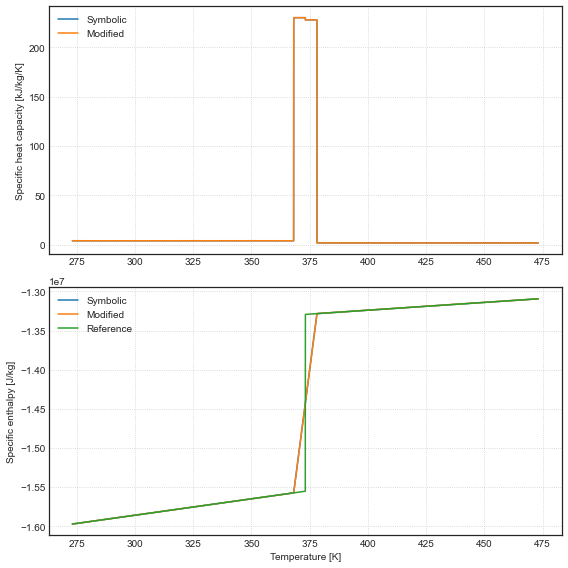

In [24]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(8, 8))

ax = plt.subplot(212)
plt.plot(T, hm_int, label="Symbolic")
plt.plot(T, hm_mod, label="Modified")
plt.plot(T, hm_ref, label="Reference")
plt.grid(linestyle=":")
plt.xlabel("Temperature [K]")
plt.ylabel("Specific enthalpy [J/kg]")
plt.legend(loc=2)

ax = plt.subplot(211, sharex=ax)
plt.plot(T, cp_int/1000, label="Symbolic")
plt.plot(T, cp_mod/1000, label="Modified")
plt.grid(linestyle=":")
plt.ylabel("Specific heat capacity [kJ/kg/K]")
plt.legend(loc=2)

plt.tight_layout()

Hope this was convincing enough to validate the approach!